# ResNet50

ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。下图是在CIFAR-10数据集上使用56层网络与20层网络训练误差和测试误差图，由图中数据可以看出，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。

![resnet-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/tutorials/application/source_zh_cn/cv/images/resnet_1.png)

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。论文中使用ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。

![resnet-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/tutorials/application/source_zh_cn/cv/images/resnet_4.png)

> 了解ResNet网络更多详细内容，参见[ResNet论文](https://arxiv.org/pdf/1512.03385.pdf)。

## 数据集准备与加载



In [1]:
'''!pip install download nltk
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)'''

'!pip install download nltk\nfrom download import download\n\nurl = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"\n\ndownload(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)'

In [2]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"  # 数据集根目录
batch_size = 256  # 批量大小
image_size = 32  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 10  # 分类数量


def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):

    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    # 数据映射操作
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


# 获取处理后的训练与测试数据集

train_dataset = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = train_dataset.get_dataset_size()

test_dataset = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = test_dataset.get_dataset_size()

## 对CIFAR-10可视化

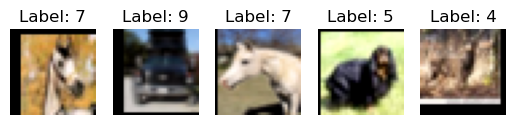

In [3]:
import mindspore as ms
from mindspore import nn, dataset as ds, Model
from mindspore.train.callback import LossMonitor
from mindspore.nn import Accuracy
from mindspore import Tensor
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
import mindspore.common.dtype as mstype
import matplotlib.pyplot as plt
import numpy as np


def visualize_dataset(dataset, num_samples=5):
    data_iter = dataset.create_dict_iterator(output_numpy=True)
    for i, data in enumerate(data_iter):
        if i * data['image'].shape[0] >= num_samples:
            break
        images = data['image']
        labels = data['label']
        batch_size = images.shape[0]
        for j in range(batch_size):
            if i * batch_size + j >= num_samples:
                break
            img = images[j]
            label = labels[j]
            img = img.transpose((1, 2, 0))  # CHW to HWC
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
            img = np.clip(img, 0, 255).astype(np.uint8)
            plt.subplot(1, num_samples, i * batch_size + j + 1)
            plt.title(f'Label: {label}')
            plt.imshow(img)
            plt.axis('off')
    plt.show()

visualize_dataset(train_dataset)

## 构造残差块

#### Building Block

如下代码定义`ResidualBlock_buildingblock`类实现Building Block结构。

In [4]:
import mindspore.nn as nn
import mindspore.ops as ops

class ResidualBlock_buildingblock(nn.Cell):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock_buildingblock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, pad_mode='same', has_bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, pad_mode='same', has_bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# 示例：构建一个 ResidualBlock
in_channels = 64
out_channels = 128
stride = 2
downsample = nn.SequentialCell([
    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, pad_mode='same', has_bias=False),
    nn.BatchNorm2d(out_channels),
])

residual_block = ResidualBlock_buildingblock(in_channels, out_channels, stride, downsample)

# 打印网络结构
print(residual_block)


ResidualBlock_buildingblock<
  (conv1): Conv2d<input_channels=64, output_channels=128, kernel_size=(3, 3), stride=(2, 2), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x000001A70CF95670>, bias_init=None, format=NCHW>
  (bn1): BatchNorm2d<num_features=128, eps=1e-05, momentum=0.9, gamma=Parameter (name=bn1.gamma, shape=(128,), dtype=Float32, requires_grad=True), beta=Parameter (name=bn1.beta, shape=(128,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=bn1.moving_mean, shape=(128,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=bn1.moving_variance, shape=(128,), dtype=Float32, requires_grad=False)>
  (relu): ReLU<>
  (conv2): Conv2d<input_channels=128, output_channels=128, kernel_size=(3, 3), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x000001A70CF95BE0>, bias_ini

#### Bottleneck
如下代码定义`ResidualBlock`类实现Bottleneck结构。

In [5]:
class ResidualBlock(nn.Cell):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, pad_mode='pad')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, pad_mode='pad')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0, pad_mode='pad')
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = nn.ReLU()
        self.downsample = downsample
        if self.downsample:
            self.shortcut = nn.SequentialCell([
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, padding=0, pad_mode='pad'),
                nn.BatchNorm2d(out_channels * 4)
            ])

    def construct(self, x):
        identity = x
        '''
        code here
        '''
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample:
            identity = self.shortcut(x)
        '''
        code here
        '''
        out += identity
        out = self.relu(out)
        
        return out

## 构建ResNet50网络


In [6]:
# 定义ResNet
class ResNet(nn.Cell):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        #self.avgpool = nn.AvgPool2d(kernel_size=4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Dense(512 * 4, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample=True))
        self.in_channels = out_channels * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        ''' code here '''
        x = self.maxpool(x)
        
        x = self.layer1(x)
        '''code here'''
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

def ResNet50(num_classes=10):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes)

## 模型训练与评估



In [7]:

# 定义模型、损失函数和优化器
resnet50 = ResNet50()
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizer = nn.Momentum(resnet50.trainable_params(), learning_rate=0.01, momentum=0.9)



In [ ]:
# 训练模型
model = Model(resnet50, loss_fn, optimizer, metrics={"accuracy": Accuracy()})
model.train(3, train_dataset, callbacks=[LossMonitor()], dataset_sink_mode=False)

# 测试模型
acc = model.eval(test_dataset, dataset_sink_mode=False)
print(f"Accuracy: {acc['accuracy']}")

#epoch经常一个都没跑完内核就崩溃了...

epoch: 1 step: 1, loss is 2.5959534645080566
epoch: 1 step: 2, loss is 2.6825971603393555
epoch: 1 step: 3, loss is 2.8021957874298096
epoch: 1 step: 4, loss is 2.71112322807312
epoch: 1 step: 5, loss is 3.065441608428955
epoch: 1 step: 6, loss is 3.1666502952575684
epoch: 1 step: 7, loss is 2.8383986949920654
epoch: 1 step: 8, loss is 3.728269100189209
epoch: 1 step: 9, loss is 3.0520477294921875
epoch: 1 step: 10, loss is 2.9363720417022705
epoch: 1 step: 11, loss is 2.883479595184326
epoch: 1 step: 12, loss is 2.606419563293457
epoch: 1 step: 13, loss is 2.788810968399048
epoch: 1 step: 14, loss is 2.5541980266571045
epoch: 1 step: 15, loss is 3.0024993419647217
epoch: 1 step: 16, loss is 3.1270382404327393
epoch: 1 step: 17, loss is 2.846365451812744
epoch: 1 step: 18, loss is 3.2122113704681396
epoch: 1 step: 19, loss is 3.493403673171997
epoch: 1 step: 20, loss is 3.7633183002471924
epoch: 1 step: 21, loss is 2.7658681869506836
epoch: 1 step: 22, loss is 3.0579514503479004
epoch:

epoch: 1 step: 180, loss is 1.7597757577896118
epoch: 1 step: 181, loss is 1.956836462020874
epoch: 1 step: 182, loss is 1.9485588073730469
epoch: 1 step: 183, loss is 1.9149922132492065
epoch: 1 step: 184, loss is 1.8941295146942139
epoch: 1 step: 185, loss is 1.7573696374893188
epoch: 1 step: 186, loss is 1.8416630029678345
epoch: 1 step: 187, loss is 1.6760321855545044
epoch: 1 step: 188, loss is 2.0148558616638184
epoch: 1 step: 189, loss is 1.9964971542358398
epoch: 1 step: 190, loss is 1.950472116470337
epoch: 1 step: 191, loss is 2.0991170406341553
epoch: 1 step: 192, loss is 2.091315269470215
epoch: 1 step: 193, loss is 1.9160339832305908
epoch: 1 step: 194, loss is 1.7830904722213745
epoch: 1 step: 195, loss is 1.7777806520462036
epoch: 1 step: 196, loss is 1.6403926610946655
epoch: 2 step: 1, loss is 2.1542394161224365
epoch: 2 step: 2, loss is 1.726283311843872
epoch: 2 step: 3, loss is 1.7717883586883545
epoch: 2 step: 4, loss is 2.039022207260132
epoch: 2 step: 5, loss is 

epoch: 2 step: 162, loss is 1.6734446287155151
epoch: 2 step: 163, loss is 2.247497797012329
epoch: 2 step: 164, loss is 1.8487952947616577
epoch: 2 step: 165, loss is 1.8060719966888428
epoch: 2 step: 166, loss is 2.0600287914276123
epoch: 2 step: 167, loss is 2.036449909210205
epoch: 2 step: 168, loss is 1.7836074829101562
epoch: 2 step: 169, loss is 2.14675235748291
epoch: 2 step: 170, loss is 1.8782756328582764
epoch: 2 step: 171, loss is 1.8207480907440186
epoch: 2 step: 172, loss is 1.8571748733520508
epoch: 2 step: 173, loss is 2.0958261489868164
epoch: 2 step: 174, loss is 1.7090507745742798
epoch: 2 step: 175, loss is 2.0666356086730957
epoch: 2 step: 176, loss is 2.2565999031066895
epoch: 2 step: 177, loss is 2.1708993911743164
epoch: 2 step: 178, loss is 2.0135083198547363
epoch: 2 step: 179, loss is 2.040787935256958
epoch: 2 step: 180, loss is 2.00156307220459
epoch: 2 step: 181, loss is 2.0151188373565674
epoch: 2 step: 182, loss is 1.9581533670425415
epoch: 2 step: 183, 